#### Poisson Equation in 2D

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from poisson import Poisson2D
import time
import torch

In [2]:
def ref_func(x, y):
    return y*(1-y)*x**3

def source_term(x, y):
    return 6*x*y*(1-y)-2*x**3

In [3]:
N=256
poisson = Poisson2D(N=N)

x = poisson.x.cpu()
BC = np.zeros((N+2, N+2))
BC[-1, 1:-1] = x.numpy() * (1 - x.numpy())


source = source_term(x[:, None], x[None, :])

/Users/jimmy/Desktop/School/NTU/112-2/計算天文物理/CGPoisson/poisson.py:60: UserWarning: Fall back to cpu for PyTorch
  self.device = "cpu"


The figure below is what analytical solution looks like under a 128-by-128 grid.

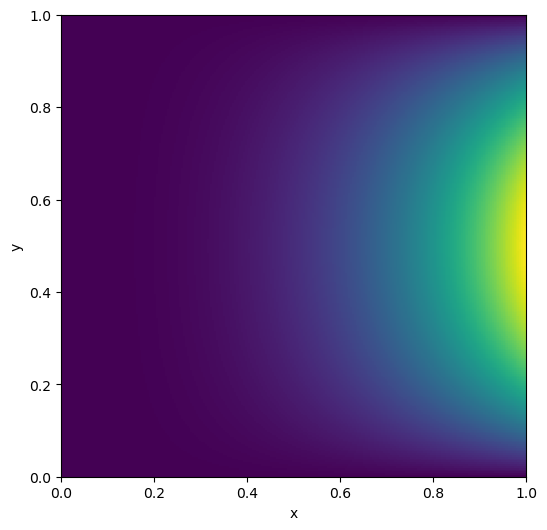

In [4]:
ref = ref_func(x[:, None], x[None, :])
fig = plt.figure(figsize=(6, 6))
fig.gca().pcolormesh(np.linspace(0, 1, N+1), np.linspace(0, 1, N+1), ref.T)
fig.gca().set_xlabel("x")
fig.gca().set_ylabel("y")
plt.show()

In [5]:
schemes = ["CG", "Gauss-Seidel", "SOR"]
resolution = np.array([2,4,8,16])
error_all = []
iters_all = []
wall_time_all = []

for scheme in schemes:
    error = []
    iters = []
    wall_time = []

    for N in resolution:
        poisson = Poisson2D(N=N)

        x = poisson.x.cpu().numpy()
        ref = ref_func(x[:, None], x[None, :])
        BC = np.zeros((N+2, N+2))
        BC[-1, 1:-1] = x * (1 - x)
        source = source_term(x[:, None], x[None, :])

        if scheme == "SOR":
            t1 = time.time()
            poisson.run(scheme=scheme, steps=None,
                        BC=torch.tensor(BC, device=poisson.device),
                        source=torch.tensor(source, device=poisson.device),
                        w=1.6905, terminate=1e-12)
            t2 = time.time()
        else:
            t1 = time.time()
            poisson.run(scheme=scheme, steps=None, BC=torch.tensor(BC, device=poisson.device),
                        source=torch.tensor(source, device=poisson.device), terminate=1e-12)
            t2 = time.time()

        error.append(np.abs(poisson.u.cpu().numpy()[1:-1, 1:-1] - ref).sum() / N**2)
        print(error)
        iters.append(poisson.steps)
        wall_time.append(t2 - t1)

    error_all.append(error)
    iters_all.append(iters)
    wall_time_all.append(wall_time)

[0.009765625000069075]
[0.009765625000069075, 0.008056640625006838]
[0.009765625000069075, 0.008056640625006838, 0.005581530987085255]
[0.009765625000069075, 0.008056640625006838, 0.005581530987085255, 0.0031432680088182945]
[0.009765625000319744]
[0.009765625000319744, 0.008056640625274551]
[0.009765625000319744, 0.008056640625274551, 0.005581530988064161]
[0.009765625000319744, 0.008056640625274551, 0.005581530988064161, 0.0031432680159070897]
[0.009765625000029388]
[0.009765625000029388, 0.008056640625244079]
[0.009765625000029388, 0.008056640625244079, 0.005581530986694127]
[0.009765625000029388, 0.008056640625244079, 0.005581530986694127, 0.003143268008693102]


a. and c. Compare the scaling between spatial resolutions and errors, iterations required and wall times required.

The scaling between resolutions and errors is expected to be (inversely) second-order. However, as shown in the first figure below, I get a scaling of (inversely) first order.

As shown in the second figure below, the scaling between resolutions and iterations required for convergence is close to second order.

As shown in the third figure below, the scaling between resolutions and wall-time required for convergence is close to fourth order.

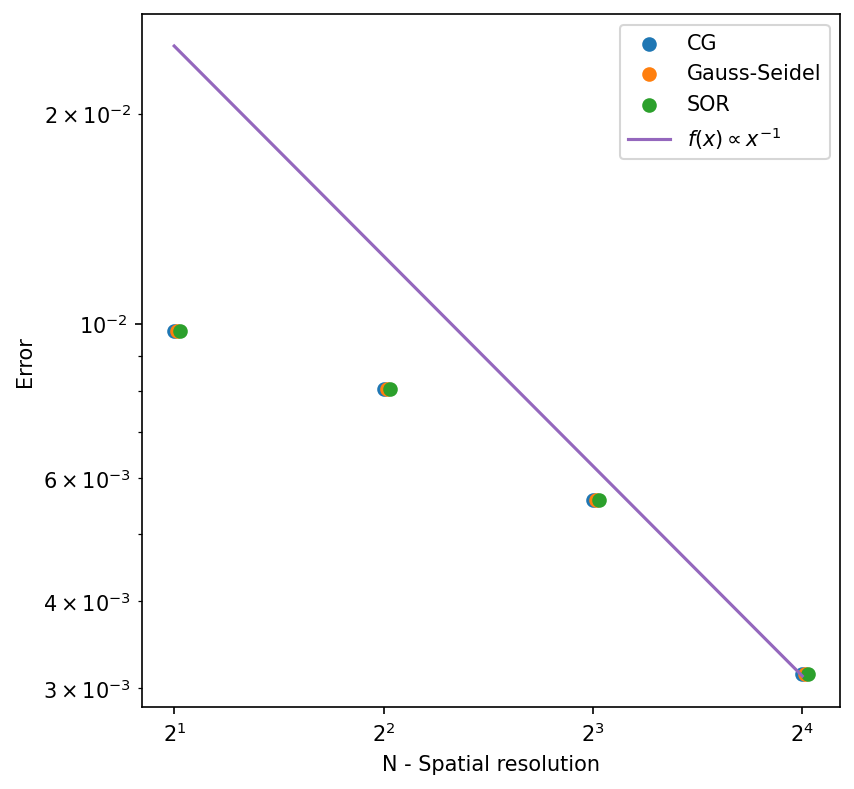

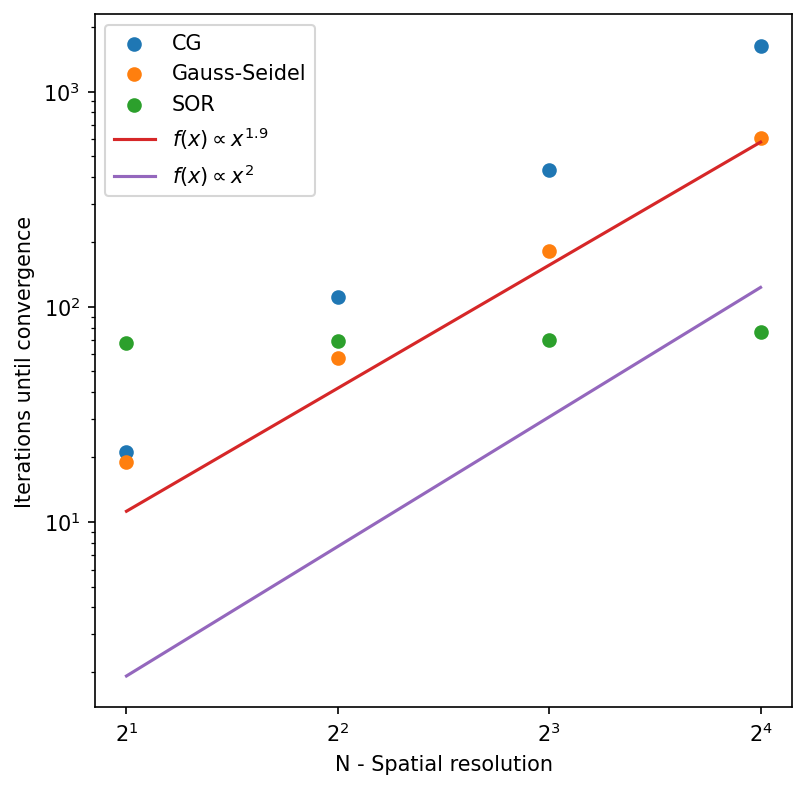

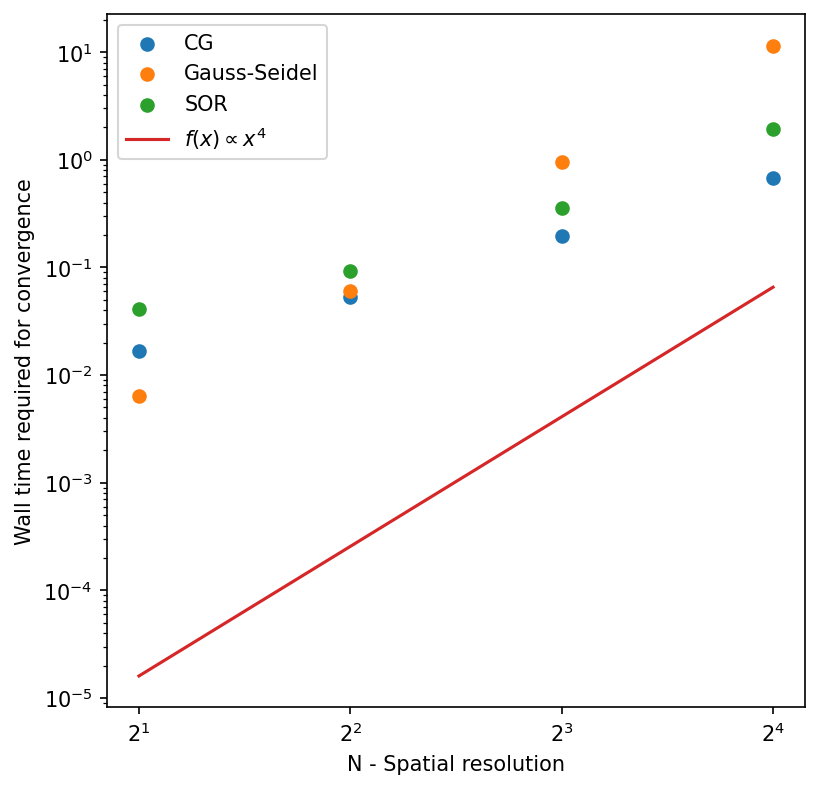

In [6]:
fig1, axes1 = plt.subplots(figsize=(6, 6), dpi=150)
fig2, axes2 = plt.subplots(figsize=(6, 6), dpi=150)
fig3, axes3 = plt.subplots(figsize=(6, 6), dpi=150)

for i, err in enumerate(error_all):
    fig1.gca().scatter(np.array(resolution)*(1+0.01*i), err, label=schemes[i])
    fig1.gca().set_yscale("log", base=10)
    fig1.gca().set_xscale("log", base=2)
    fig1.gca().set_xlabel("N - Spatial resolution")
    fig1.gca().set_ylabel("Error")

for i, iter in enumerate(iters_all):
    fig2.gca().scatter(resolution, iter, label=schemes[i])
    fig2.gca().set_yscale("log", base=10)
    fig2.gca().set_xscale("log", base=2)
    fig2.gca().set_xlabel("N - Spatial resolution")
    fig2.gca().set_ylabel("Iterations until convergence")

for i, _wall_time in enumerate(wall_time_all):
    fig3.gca().scatter(resolution, _wall_time, label=schemes[i])
    fig3.gca().set_yscale("log", base=10)
    fig3.gca().set_xscale("log", base=2)
    fig3.gca().set_xlabel("N - Spatial resolution")
    fig3.gca().set_ylabel("Wall time required for convergence")


res = np.linspace(resolution[0], resolution[-1], 1000)
#fig1.gca().plot(res, res**(-2), label=r"$f(x) \propto x^{-2}$", c='C3')
fig1.gca().plot(res, 5e-2*res**(-1), label=r"$f(x) \propto x^{-1}$", c='C4')
fig2.gca().plot(res, 3*res**(1.9), label=r"$f(x) \propto x^{1.9}$", c='C3')
fig2.gca().plot(res, 0.48*res**(2), label=r"$f(x) \propto x^{2}$", c='C4')
fig3.gca().plot(res, 1e-6*res**(4), label=r"$f(x) \propto x^{4}$", c='C3')
fig1.gca().legend()
fig2.gca().legend()
fig3.gca().legend()

plt.show()